# Reference

https://arxiv.org/abs/1611.06455



## Setup

In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! wget https://gea-dataset.s3.ap-northeast-2.amazonaws.com/eeg_fpz_cz.csv

--2022-01-17 04:07:22--  https://gea-dataset.s3.ap-northeast-2.amazonaws.com/eeg_fpz_cz.csv
Resolving gea-dataset.s3.ap-northeast-2.amazonaws.com (gea-dataset.s3.ap-northeast-2.amazonaws.com)... 52.219.148.78
Connecting to gea-dataset.s3.ap-northeast-2.amazonaws.com (gea-dataset.s3.ap-northeast-2.amazonaws.com)|52.219.148.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1328429860 (1.2G) [text/csv]
Saving to: ‘eeg_fpz_cz.csv’

eeg_fpz_cz.csv      100%[===================>]   1.24G  24.5MB/s    in 53s     

2022-01-17 04:08:16 (23.8 MB/s) - ‘eeg_fpz_cz.csv’ saved [1328429860/1328429860]



In [1]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def readucr(filename):
    data = pd.read_csv(filename)
    y = data.iloc[:, -1]
    x = data.iloc[:, :-1]
    return x, y.astype(int)


root_url = "/content/eeg_fpz_cz.csv"

x_data, y_data = readucr(root_url)

n_classes = len(np.unique(y_data))

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, stratify = y_data)
x_train = np.array(x_train).reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0],x_test.shape[1], 1)

ModuleNotFoundError: No module named 'sklearn'

## Visualize the data

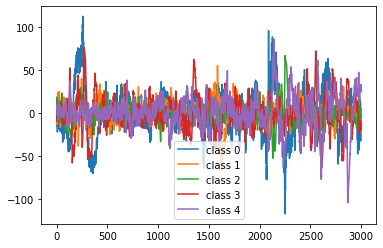

In [ ]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [ ]:
num_classes = len(np.unique(y_train))

## Build a model

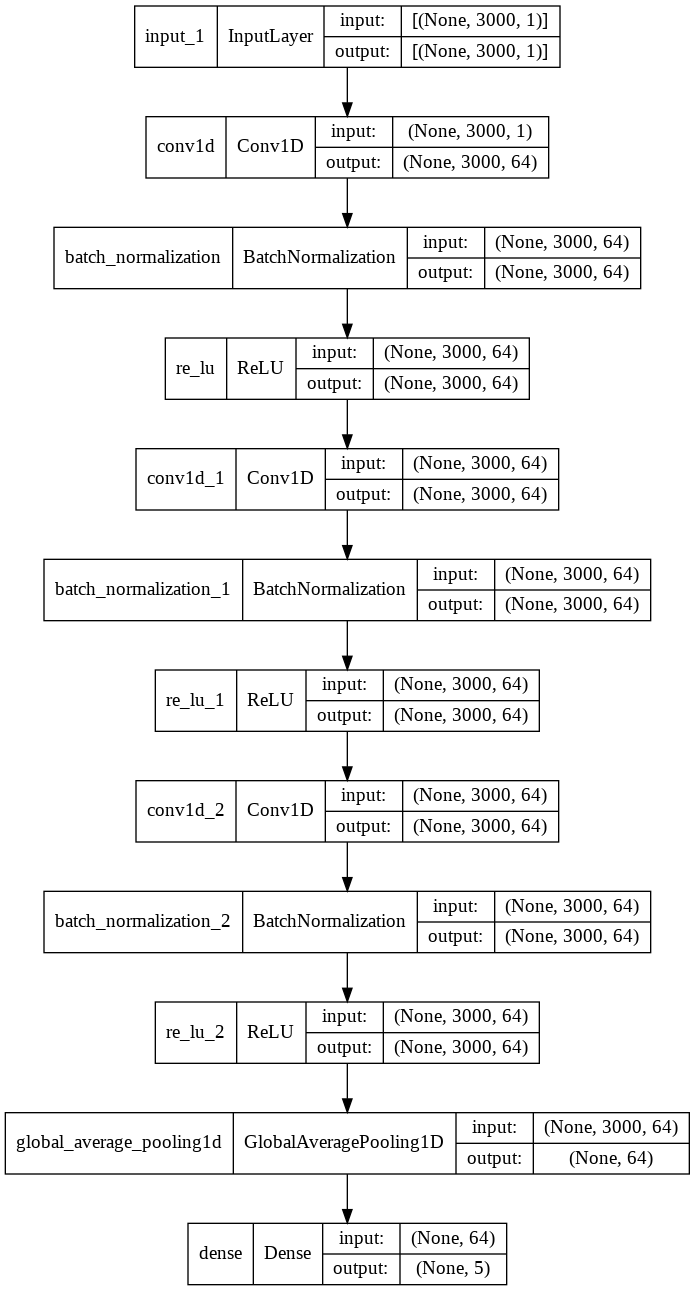

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
epochs = 500
batch_size = 4

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=2),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['sparse_categorical_accuracy'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=100,
    callbacks=callbacks,
    validation_data=(x_test,y_test),
    verbose=1,
)

Epoch 1/100
8172/8172 [==============================] - 59s 7ms/step - loss: 0.8670 - sparse_categorical_accuracy: 0.6729 - val_loss: 0.7716 - val_sparse_categorical_accuracy: 0.7334 - lr: 0.0010
Epoch 2/100
8172/8172 [==============================] - 58s 7ms/step - loss: 0.7609 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.7167 - val_sparse_categorical_accuracy: 0.7427 - lr: 0.0010
Epoch 3/100
8172/8172 [==============================] - 57s 7ms/step - loss: 0.7161 - sparse_categorical_accuracy: 0.7344 - val_loss: 0.6292 - val_sparse_categorical_accuracy: 0.7801 - lr: 0.0010
Epoch 4/100
8172/8172 [==============================] - 57s 7ms/step - loss: 0.6865 - sparse_categorical_accuracy: 0.7458 - val_loss: 0.6525 - val_sparse_categorical_accuracy: 0.7629 - lr: 0.0010
Epoch 5/100
8172/8172 [==============================] - 52s 6ms/step - loss: 0.6639 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.6243 - val_sparse_categorical_accuracy: 0.7726 - lr: 0.0010
Epoch 6/100
817

## Evaluate model on test data

In [ ]:
model.evaluate(x_test, y_test, verbose=1, batch_size=4)

y_pred = model.predict(x_test, batch_size=4)

model.save('my_model.h5')

pred = []
for i in range(len(y_pred)):
    a = np.argmax(y_pred[i])
    pred.append(a)
np.save("y_pred", np.array(pred))
np.save("y_test", np.array(y_test))

print(len(pred))
print(len(y_test))

2724/2724 [==============================] - 7s 2ms/step - loss: 0.5743 - sparse_categorical_accuracy: 0.7986
10896
10896


In [ ]:
from os import path

notebooks_dir_name = '새 폴더'
notebooks_base_dir = path.join('./drive/My Drive/', notebooks_dir_name)
if not path.exists(notebooks_base_dir):
  print('Check your google drive directory. See you file explorer')


with open(path.join(notebooks_base_dir, "y_pred_cnn.txt"), "w") as f:
    f.write(str(pred))
with open(path.join(notebooks_base_dir, "y_test_cnn.txt"), "w") as f:
    f.write(str(y_test))

In [ ]:
from sklearn.metrics import f1_score

print("f1_marco :", f1_score(y_test, pred, average='macro'))
print("f1_micro :", f1_score(y_test, pred, average='micro'))
print("f1_weighted :", f1_score(y_test, pred, average='weighted'))

f1_marco : 0.6872696040102855
f1_micro : 0.7986417033773863
f1_weighted : 0.7826126413617606
